In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_curve, auc, RocCurveDisplay
from keras.preprocessing import image
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     GlobalAveragePooling2D, Dense, Dropout, Activation)
#from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
#from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""import zipfile
import os
# 2. Path to your zip file (update with your actual path & filename)
zip_path = '/content/drive/MyDrive/A Stroke detection dataset final.zip'
# 3. Folder where you want to extract files
extract_path = '/content/drive/MyDrive/Stroke detection unzipped'

# 4. Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Files extracted to:", extract_path)

# 5. Check extracted files
print(os.listdir(extract_path))"""

'import zipfile\nimport os\n# 2. Path to your zip file (update with your actual path & filename)\nzip_path = \'/content/drive/MyDrive/A Stroke detection dataset final.zip\'\n# 3. Folder where you want to extract files\nextract_path = \'/content/drive/MyDrive/Stroke detection unzipped\'\n\n# 4. Unzip the file\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n    zip_ref.extractall(extract_path)\n\nprint("✅ Files extracted to:", extract_path)\n\n# 5. Check extracted files\nprint(os.listdir(extract_path))'

In [ ]:
# Set up constants
data_dir = '/content/drive/MyDrive/Stroke detection unzipped/main'
categories = ['noStroke_data', 'stroke_data']
img_size = 48  # Resizing images to 48x48
batch_size = 32
num_classes = 2

In [ ]:
# Helper function to load and preprocess the dataset
def load_data(data_dir, categories, img_size):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)  # 0 for no stroke, 1 for stroke
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale images
                img = cv2.resize(img, (img_size, img_size))
                data.append([img, label])
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    return data

In [ ]:
# Load dataset
data = load_data(data_dir, categories, img_size)
np.random.shuffle(data)

In [ ]:
#verifying the dataset loading
print("Total images:", len(data))
print("Stroke samples:", sum(1 for _, label in data if label == 1))
print("No Stroke samples:", sum(1 for _, label in data if label == 0))

Total images: 3770
Stroke samples: 1259
No Stroke samples: 2511


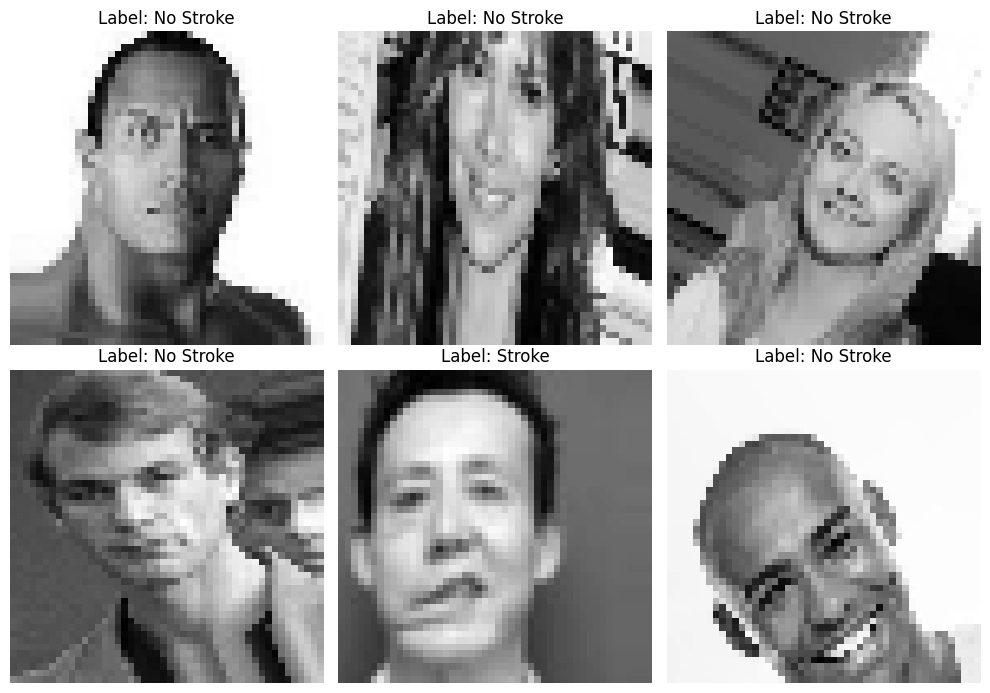

In [ ]:
# Display the first 5-6 images with labels
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # Adjust the grid size as needed
axes = axes.ravel()

for i in range(6):  # Display the first 6 images
    img, label = data[i]
    axes[i].imshow(img, cmap='gray')  # Show the image
    axes[i].set_title(f"Label: {'Stroke' if label == 1 else 'No Stroke'}")  # Set the title with the label
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [ ]:
# Split features and labels
x_data = np.array([item[0] for item in data]).reshape(-1, img_size, img_size, 1) / 255.0  # Normalize
y_data = np.array([item[1] for item in data])
y_data = tf.keras.utils.to_categorical(y_data, num_classes)

In [ ]:
# Split the dataset
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2639, 48, 48, 1), (566, 48, 48, 1), (2639, 2), (566, 2))

In [ ]:
# Data Augmentation
"""datagen = ImageDataGenerator(
    rotation_range=40,  # Increased rotation range
    zoom_range=0.3,     # Increased zoom range
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'  # Added fill_mode for better image handling
)"""

# Data Augmentation Simplified Version
datagen = ImageDataGenerator(horizontal_flip=True)

datagen.fit(x_train)

In [ ]:
# Model Architecture
"""model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Reduced Dense units
    Dropout(0.3),
    Dense(num_classes, activation='sigmoid')
])"""

model= Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1), padding='same'),MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)),

GlobalAveragePooling2D(),
Dense(128, activation='relu'),
Dropout(0.3),
Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Adjust class weights#
#from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Compute class weights based on the distribution of the data#
"""class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(np.argmax(y_data, axis=1)),
                                     y=np.argmax(y_data, axis=1))"""

"class_weights = compute_class_weight(class_weight='balanced',\n                                     classes=np.unique(np.argmax(y_data, axis=1)),\n                                     y=np.argmax(y_data, axis=1))"

In [ ]:
"""class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)"""

'class_weights = dict(enumerate(class_weights))\nprint("Class Weights:", class_weights)'

In [ ]:
# Compile the model with sensitivity as a monitored metric
#from tensorflow.keras.metrics import Recall

In [ ]:
# Compile the model with a higher learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # Learning rate remains the same
              loss='categorical_crossentropy',
              metrics=['accuracy'])  # Adding Recall to metrics

In [ ]:
# Callbacks for early stopping and learning rate adjustment
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [ ]:
# Train the model with class weights
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val),
                    epochs=30,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.6744 - loss: 0.6358 - val_accuracy: 0.6637 - val_loss: 0.5847 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.6576 - loss: 0.6050 - val_accuracy: 0.6637 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.6909 - loss: 0.5223 - val_accuracy: 0.7664 - val_loss: 0.5140 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.7574 - loss: 0.4824 - val_accuracy: 0.7310 - val_loss: 0.5034 - learning_rate: 0.0010
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.7641 - loss: 0.4844 - val_accuracy: 0.8088 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.7739 - loss: 0.4798 - val_accuracy: 0.7788 - val_loss: 0.3952 - learning_rate: 0.0010
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.7872 - loss: 0.4050 - val_

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

In [ ]:
results = model.evaluate(x_test, y_test, return_dict=True)
print(f"Test Accuracy: {results['accuracy'] * 100:.2f}%")
#print(f"Test Recall (Sensitivity): {results['recall'] * 100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9628 - loss: 0.0803
Test Accuracy: 96.64%


In [ ]:
# Calculate sensitivity (Recall)
#y_pred = np.argmax(model.predict(x_test), axis=1)
#y_true = np.argmax(y_test, axis=1)
#test_sensitivity = recall_score(y_true, y_pred)
#print(f"Test Sensitivity (Recall): {test_sensitivity * 100:.2f}%")

In [ ]:
# Get prediction probabilities for both classes
y_pred_prob = model.predict(x_test)

# Focus on the probability of the 'stroke' class (index 1)
y_pred_prob_stroke = y_pred_prob[:, 1]

# Apply threshold (default is 0.5, you are lowering to 0.3 to increase sensitivity)
threshold = 0.3
y_pred_adjusted = (y_pred_prob_stroke > threshold).astype(int)

# Get true labels
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix_adjusted = confusion_matrix(y_true, y_pred_adjusted)
print("Confusion Matrix (Adjusted Threshold):\n", conf_matrix_adjusted)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_adjusted, target_names=categories))

# Individual Metrics
print("Precision:", precision_score(y_true, y_pred_adjusted))
print("Recall (Sensitivity):", recall_score(y_true, y_pred_adjusted))
print("F1-score:", f1_score(y_true, y_pred_adjusted))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Confusion Matrix (Adjusted Threshold):
 [[341  23]
 [  2 200]]
Classification Report:
                precision    recall  f1-score   support

noStroke_data       0.99      0.94      0.96       364
  stroke_data       0.90      0.99      0.94       202

     accuracy                           0.96       566
    macro avg       0.95      0.96      0.95       566
 weighted avg       0.96      0.96      0.96       566

Precision: 0.8968609865470852
Recall (Sensitivity): 0.9900990099009901
F1-score: 0.9411764705882353


In [ ]:
# 6. Metrics
conf_matrix = confusion_matrix(y_true, y_pred_adjusted)
print("\n📌 Confusion Matrix (Adjusted Threshold):\n", conf_matrix)

print("\n📌 Classification Report:")
print(classification_report(y_true, y_pred_adjusted, target_names=categories))

print("🔹 Accuracy:", accuracy_score(y_true, y_pred_adjusted))
print("🔹 Precision:", precision_score(y_true, y_pred_adjusted))
print("🔹 Recall (Sensitivity):", recall_score(y_true, y_pred_adjusted))
print("🔹 F1-score:", f1_score(y_true, y_pred_adjusted))


📌 Confusion Matrix (Adjusted Threshold):
 [[341  23]
 [  2 200]]

📌 Classification Report:
               precision    recall  f1-score   support

noStroke_data       0.99      0.94      0.96       364
  stroke_data       0.90      0.99      0.94       202

     accuracy                           0.96       566
    macro avg       0.95      0.96      0.95       566
 weighted avg       0.96      0.96      0.96       566

🔹 Accuracy: 0.9558303886925795
🔹 Precision: 0.8968609865470852
🔹 Recall (Sensitivity): 0.9900990099009901
🔹 F1-score: 0.9411764705882353


In [ ]:
# Recalculate confusion matrix and metrics
y_true = np.argmax(y_test, axis=1)
conf_matrix_adjusted = confusion_matrix(y_true, y_pred_adjusted)
print("Confusion Matrix (Adjusted Threshold):\n", conf_matrix_adjusted)

Confusion Matrix (Adjusted Threshold):
 [[341  23]
 [  2 200]]


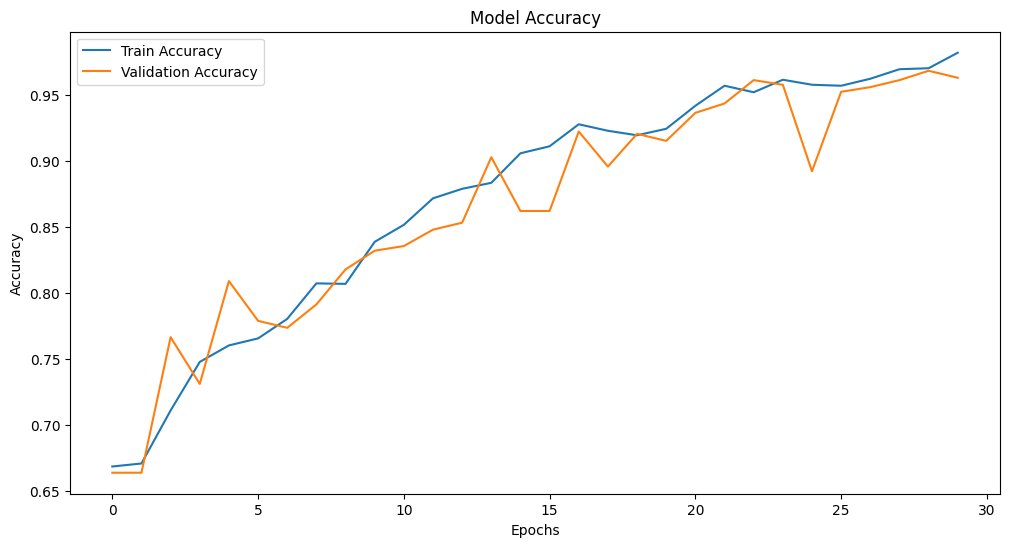

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

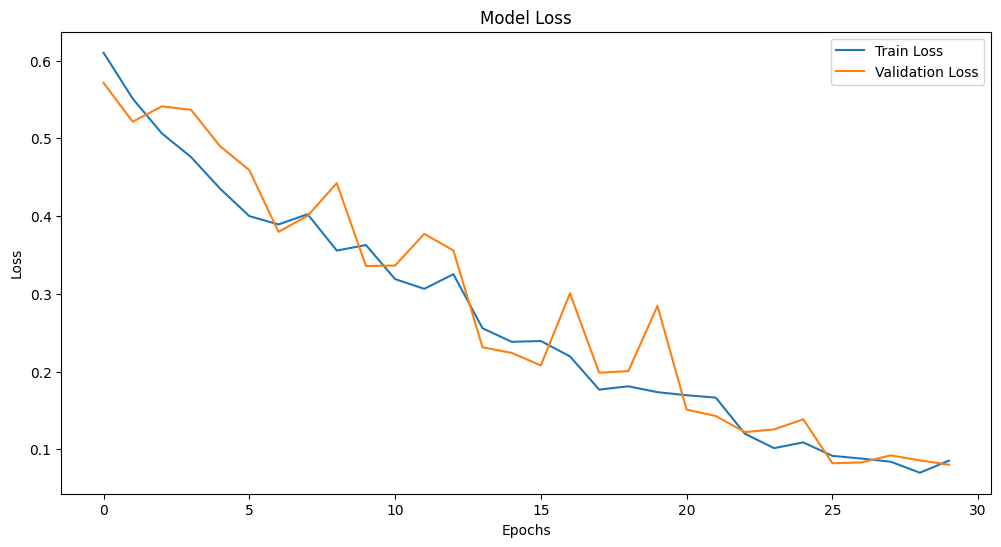

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# AUC and ROC Curve
fpr, tpr, _ = roc_curve(y_true, model.predict(x_test)[:, 1])  # For binary classification (e.g., 1 vs 0)
roc_auc = auc(fpr, tpr)
print(f"Test AUC: {roc_auc:.2f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Test AUC: 1.00


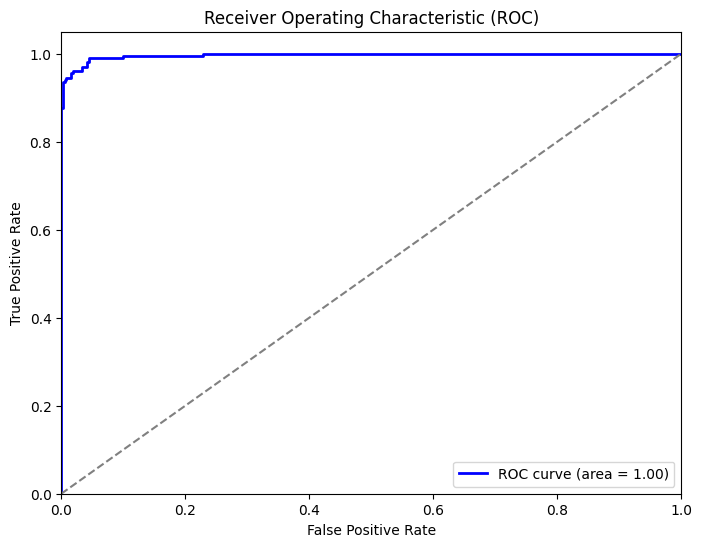

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

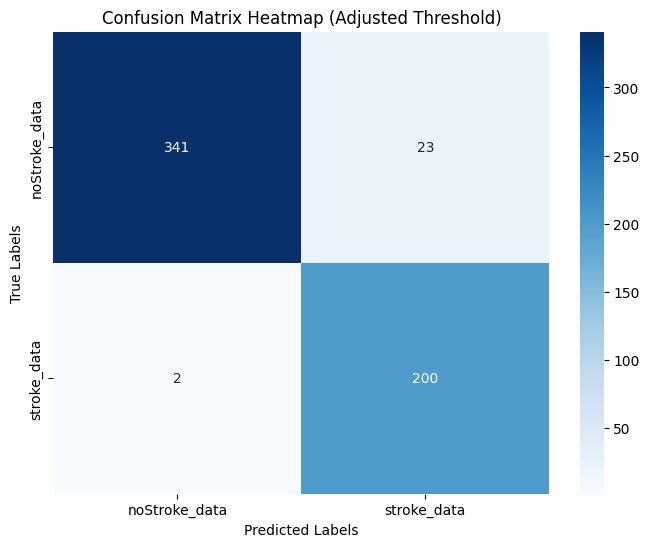

In [ ]:
# Heatmap for the adjusted confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix Heatmap (Adjusted Threshold)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


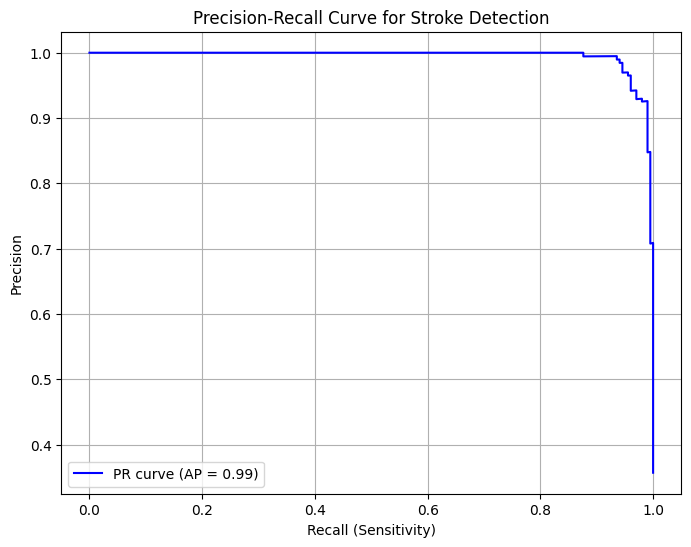

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get prediction probabilities for stroke class (index 1)
y_pred_prob_stroke = model.predict(x_test)[:, 1]

# True labels
y_true = np.argmax(y_test, axis=1)

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob_stroke)

# Compute Average Precision (area under PR curve)
avg_precision = average_precision_score(y_true, y_pred_prob_stroke)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Stroke Detection')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [ ]:
def predict_stroke(dir_path, model, img_size, num_images=5):
    count = 0
    for img_name in os.listdir(dir_path):
        if count >= num_images:  # Stop after processing the specified number of images
            break

        img_path = os.path.join(dir_path, img_name)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(img_size, img_size), color_mode='grayscale')

        # Display the image
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicting stroke for {img_name}")
        plt.axis('off')  # Hide axes for better visual
        plt.show()

        # Convert image to array and normalize
        x = image.img_to_array(img) / 255.0  # Normalize pixel values to [0,1]
        x = np.expand_dims(x, axis=0)  # Add batch dimension

        # Predict stroke using the trained model
        prediction = np.argmax(model.predict(x))

        # Print the prediction result
        if prediction == 0:
            print(f"Result for {img_name}: Stroke is NOT detected.")
        else:
            print(f"Result for {img_name}: Stroke is detected.")

        count += 1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


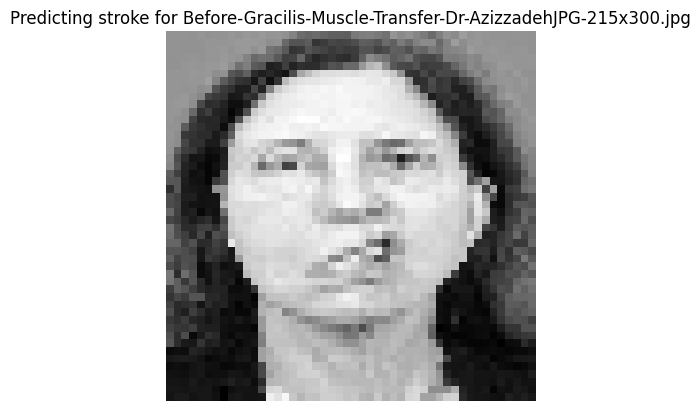

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Result for Before-Gracilis-Muscle-Transfer-Dr-AzizzadehJPG-215x300.jpg: Stroke is detected.


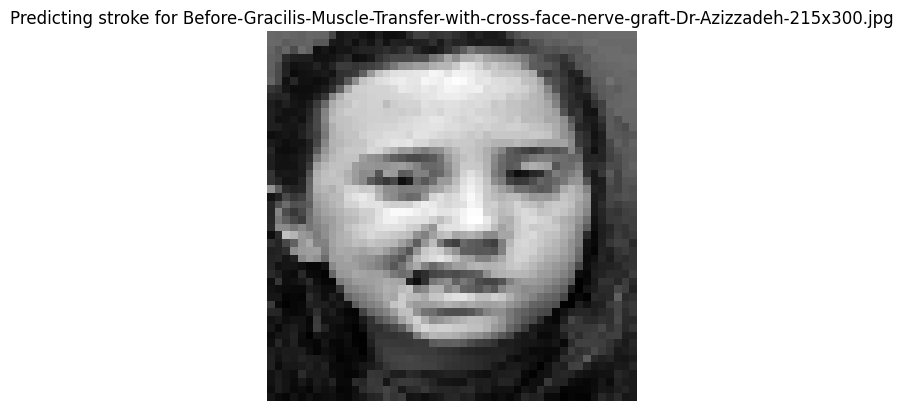

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Result for Before-Gracilis-Muscle-Transfer-with-cross-face-nerve-graft-Dr-Azizzadeh-215x300.jpg: Stroke is detected.


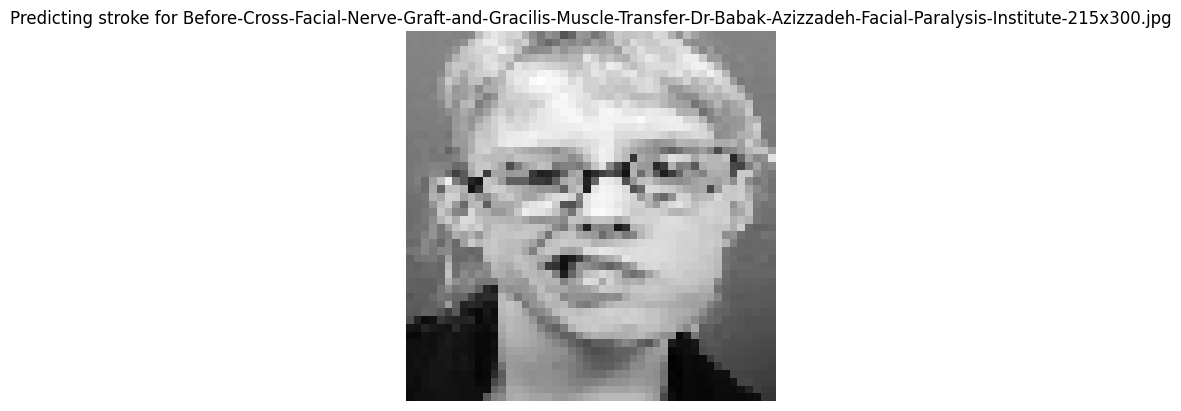

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Result for Before-Cross-Facial-Nerve-Graft-and-Gracilis-Muscle-Transfer-Dr-Babak-Azizzadeh-Facial-Paralysis-Institute-215x300.jpg: Stroke is detected.


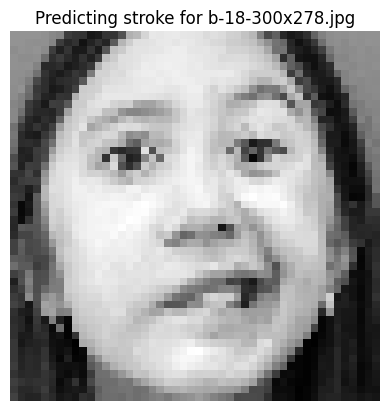

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Result for b-18-300x278.jpg: Stroke is detected.


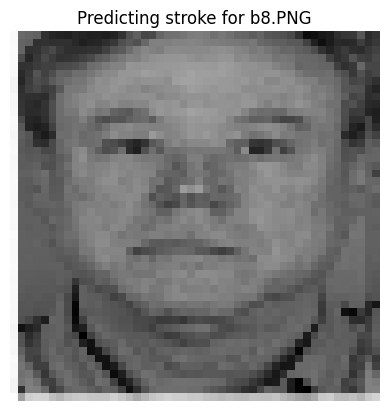

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Result for b8.PNG: Stroke is detected.


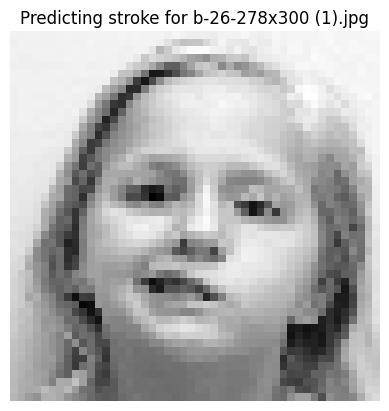

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Result for b-26-278x300 (1).jpg: Stroke is detected.


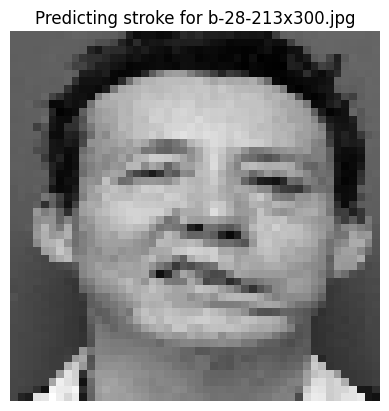

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Result for b-28-213x300.jpg: Stroke is detected.


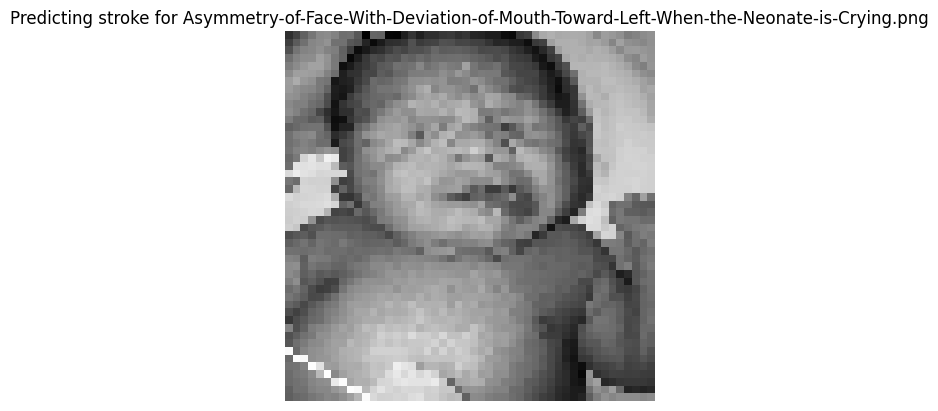

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Result for Asymmetry-of-Face-With-Deviation-of-Mouth-Toward-Left-When-the-Neonate-is-Crying.png: Stroke is detected.


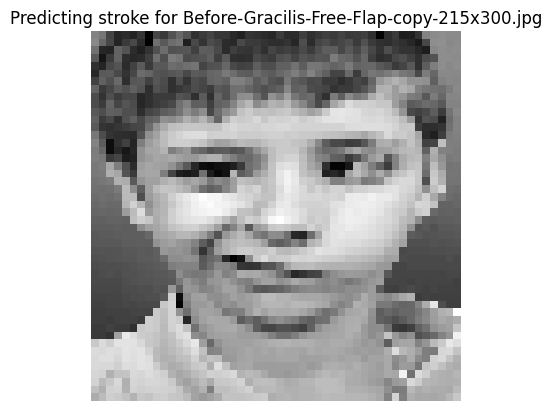

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Result for Before-Gracilis-Free-Flap-copy-215x300.jpg: Stroke is detected.


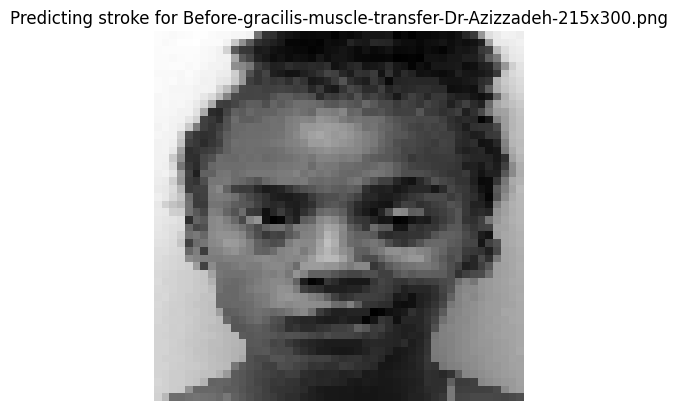

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Result for Before-gracilis-muscle-transfer-Dr-Azizzadeh-215x300.png: Stroke is NOT detected.


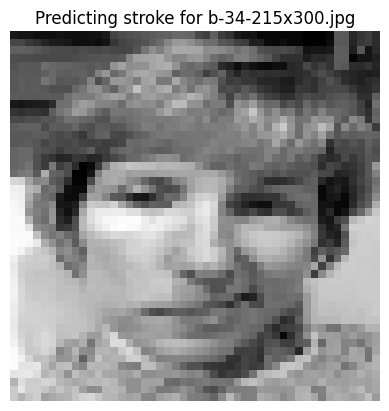

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Result for b-34-215x300.jpg: Stroke is detected.


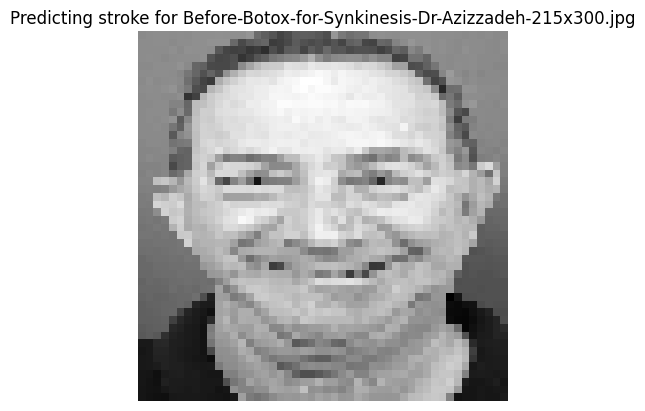

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Result for Before-Botox-for-Synkinesis-Dr-Azizzadeh-215x300.jpg: Stroke is detected.


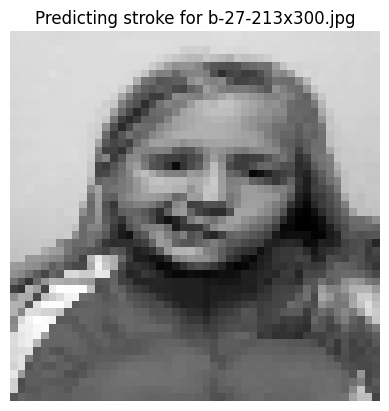

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Result for b-27-213x300.jpg: Stroke is detected.


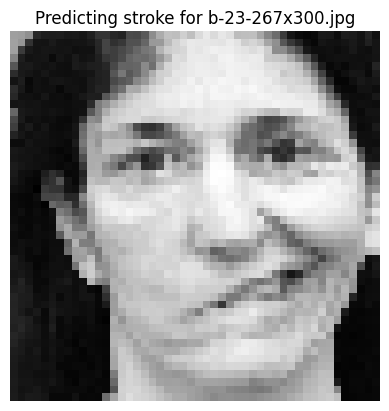

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Result for b-23-267x300.jpg: Stroke is NOT detected.


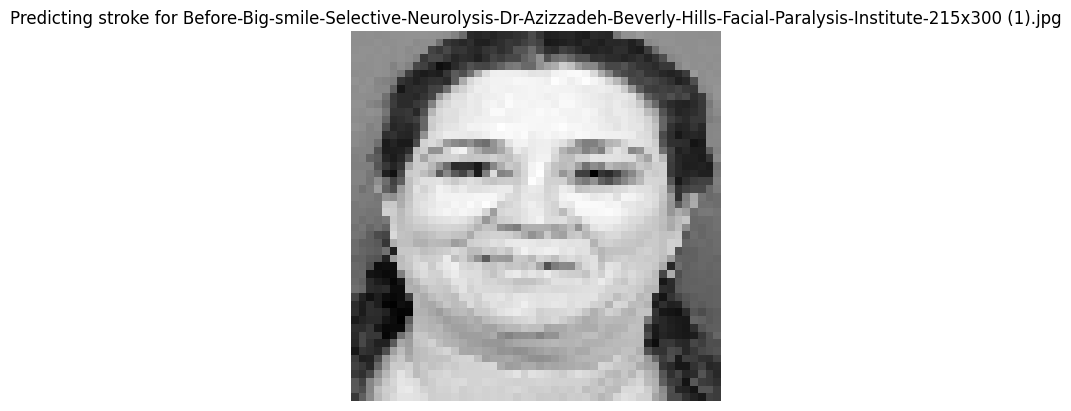

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Result for Before-Big-smile-Selective-Neurolysis-Dr-Azizzadeh-Beverly-Hills-Facial-Paralysis-Institute-215x300 (1).jpg: Stroke is detected.


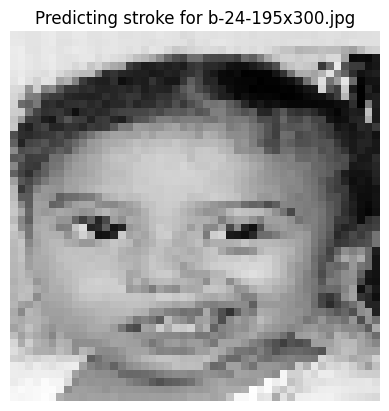

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Result for b-24-195x300.jpg: Stroke is NOT detected.


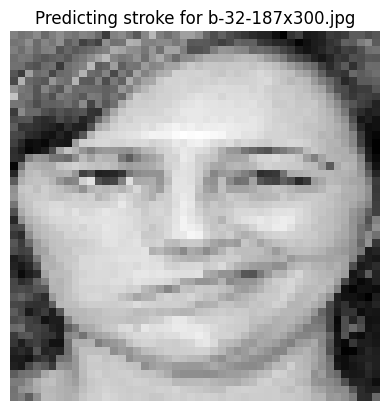

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Result for b-32-187x300.jpg: Stroke is detected.


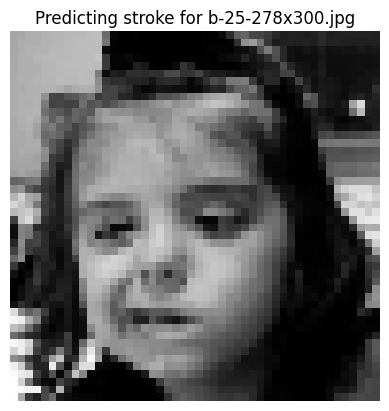

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Result for b-25-278x300.jpg: Stroke is NOT detected.


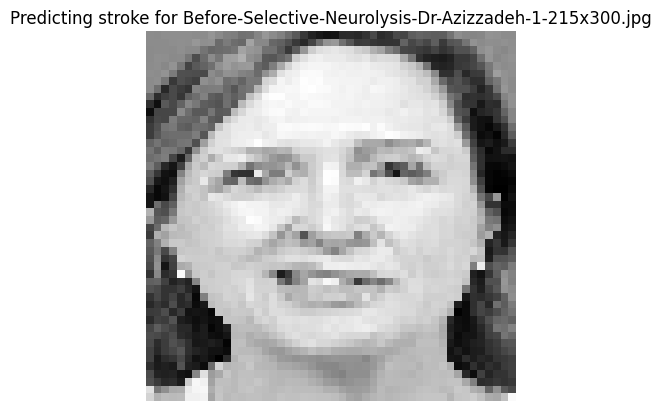

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Result for Before-Selective-Neurolysis-Dr-Azizzadeh-1-215x300.jpg: Stroke is detected.


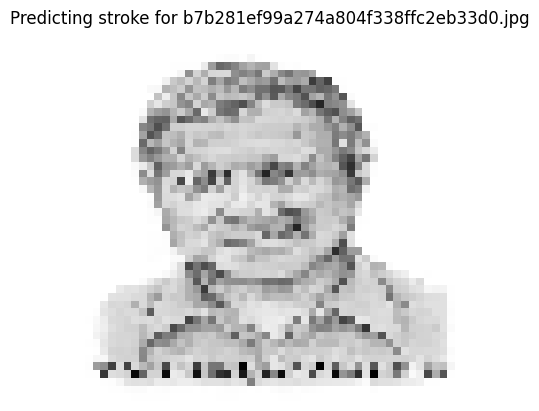

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Result for b7b281ef99a274a804f338ffc2eb33d0.jpg: Stroke is NOT detected.


In [ ]:
#Wait, I have to run this again, after making test file
predict_stroke("/content/drive/MyDrive/Stroke detection unzipped/Strokefaces/droopy", model, img_size, num_images=20)

In [ ]:
# Assuming `model` is your trained model
model.save('model.h5')